In [1]:
!pip install adversarial-robustness-toolbox

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.5/30.5 MB 52.8 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 0.19.2 requires scikit-learn>=1.2.2, but you have scikit-learn 1.1.3 which is incompatible.


In [2]:
import cv2
import os
import torch
import random
import pickle
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.applications import ResNet50
from keras.applications import VGG16
from keras.applications.resnet50 import preprocess_input
from keras.preprocessing import image
from keras.models import load_model, save_model
from keras.layers import Dense, Flatten, GlobalAveragePooling2D
from keras.models import Model
from keras.optimizers import Adam
from keras.losses import categorical_crossentropy
from keras.metrics import categorical_accuracy
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, AvgPool2D, BatchNormalization, Reshape, Lambda
from art.estimators.classification import KerasClassifier
from art.attacks.evasion import FastGradientMethod, ProjectedGradientDescent
%matplotlib inline

In [3]:
from google.colab import drive
drive.mount('/content/drive')
zip_file = '/content/drive/MyDrive/data/archive (1).zip'
z = zipfile.ZipFile(zip_file, 'r')
z.extractall()

Mounted at /content/drive


In [4]:
data_path = '/content'
train_data_path = os.path.join(data_path, 'Train')
test_data_path = os.path.join(data_path, 'Test')
meta_data_path = os.path.join(data_path, 'Meta')

In [5]:
data = []
labels = []
class_count = 43
for i in range(class_count):
    img_path = os.path.join(train_data_path, str(i))
    for img in os.listdir(img_path):
        img = image.load_img(img_path + '/' + img, target_size=(32, 32))
        img_array = image.img_to_array(img)
        img_array = img_array / 255
        data.append(img_array)
        labels.append(i)
data = np.array(data)
labels = np.array(labels)
labels = to_categorical(labels, 43)
print("data[0]:\n",data[0])

data[0]:
 [[[1.         1.         1.        ]
  [1.         1.         1.        ]
  [1.         1.         1.        ]
  ...
  [1.         1.         1.        ]
  [1.         1.         1.        ]
  [1.         1.         1.        ]]

 [[1.         1.         1.        ]
  [1.         1.         1.        ]
  [1.         1.         1.        ]
  ...
  [1.         1.         1.        ]
  [1.         1.         1.        ]
  [1.         1.         1.        ]]

 [[1.         1.         1.        ]
  [1.         1.         1.        ]
  [1.         1.         1.        ]
  ...
  [1.         1.         1.        ]
  [1.         1.         1.        ]
  [1.         1.         1.        ]]

 ...

 [[1.         1.         0.92941177]
  [1.         1.         0.9529412 ]
  [1.         1.         0.9764706 ]
  ...
  [0.90588236 0.8156863  0.6901961 ]
  [0.6156863  0.49411765 0.3254902 ]
  [0.34901962 0.33333334 0.24705882]]

 [[1.         1.         0.9411765 ]
  [1.         1.         0.

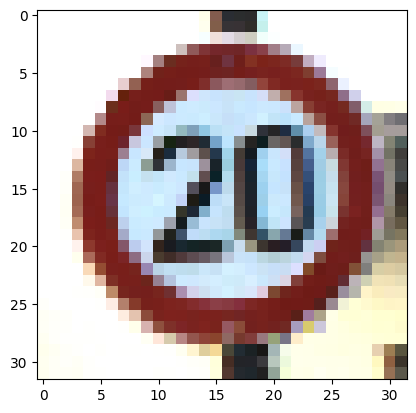

In [6]:
plt.imshow(data[0])

In [7]:
x_train, x_val, y_train, y_val = train_test_split(data, labels, test_size=0.3, random_state=1)

# размерности обучающего и тестового набора и первый элемент
print("training shape: ",x_train.shape, y_train.shape)
print("testing shape: ",x_val.shape, y_val.shape)
print(y_train[0])

training shape:  (27446, 32, 32, 3) (27446, 43)
testing shape:  (11763, 32, 32, 3) (11763, 43)
[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [8]:
model = Sequential()
model.add(ResNet50(include_top = False, pooling = 'avg'))
model.add(Dropout(0.1))
model.add(Dense(256, activation="relu"))
model.add(Dropout(0.1))
model.add(Dense(43, activation = 'softmax'))
model.layers[2].trainable = False
print(model.summary())

94765736/94765736 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 43)                11051     
                                                                 
Total params: 24123307 (92.02 MB)
Trainable params: 23545643 (89.82 MB)
Non-trainable params: 577664 (2.20 MB)
____________

In [9]:
# обучение модели в течение 5 эпох, используя оптимизатор Adam и
# функция потерь categorical crossentropy
model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])
# сохранение истории обучения для последующего анализа
history = model.fit(x_train, y_train, validation_data =(x_val, y_val), epochs = 5, batch_size = 64)

Epoch 1/5
429/429 [==============================] - 71s 73ms/step - loss: 0.8858 - accuracy: 0.7627 - val_loss: 9.0273 - val_accuracy: 0.1910
Epoch 2/5
429/429 [==============================] - 26s 60ms/step - loss: 0.1971 - accuracy: 0.9478 - val_loss: 3.4866 - val_accuracy: 0.7967
Epoch 3/5
429/429 [==============================] - 24s 56ms/step - loss: 0.1344 - accuracy: 0.9651 - val_loss: 0.7037 - val_accuracy: 0.8520
Epoch 4/5
429/429 [==============================] - 28s 64ms/step - loss: 0.1144 - accuracy: 0.9696 - val_loss: 0.2086 - val_accuracy: 0.9466
Epoch 5/5
429/429 [==============================] - 24s 57ms/step - loss: 0.0994 - accuracy: 0.9765 - val_loss: 0.1030 - val_accuracy: 0.9705


In [10]:
save_model(model, 'ResNet50.h5')
test = pd.read_csv("Test.csv")
test_imgs = test['Path'].values
data = []

for img in test_imgs:
    img = image.load_img(img, target_size=(32, 32))
    img_array = image.img_to_array(img)
    img_array = img_array / 255
    data.append(img_array)

data = np.array(data)
y_test = test['ClassId'].values.tolist()
y_test = np.array(y_test)
y_test = to_categorical(y_test, 43)

<ipython-input-10-3bd597514022>:1: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  save_model(model, 'ResNet50.h5')


In [11]:
# создание модели для классификации изображений (VGG16)
model2 = Sequential()
model2.add(VGG16(include_top=False, pooling = 'avg'))
model2.add(Dropout(0.1))
model2.add(Dense(256, activation="relu"))
model2.add(Dropout(0.1))
model2.add(Dense(43, activation = 'softmax'))
model2.layers[2].trainable = False
# отобразим итоговую сводку по модели
print(model2.summary())

58889256/58889256 [==============================] - 0s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 256)               131328    
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 43)                11051     
                                                                 
Total params: 14857067 (56.68 MB)
Trainable params: 14725739 (56.17 MB)
Non-trainable params: 131328 (513.00 KB)
________

In [12]:
model2.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])
history2 = model2.fit(x_train, y_train, validation_data =(x_val, y_val), epochs = 5, batch_size = 64)

Epoch 1/5
429/429 [==============================] - 28s 49ms/step - loss: 2.4699 - accuracy: 0.2799 - val_loss: 1.1879 - val_accuracy: 0.5980
Epoch 2/5
429/429 [==============================] - 17s 41ms/step - loss: 0.7134 - accuracy: 0.7603 - val_loss: 0.3030 - val_accuracy: 0.9040
Epoch 3/5
429/429 [==============================] - 18s 42ms/step - loss: 0.2431 - accuracy: 0.9261 - val_loss: 0.1900 - val_accuracy: 0.9441
Epoch 4/5
429/429 [==============================] - 17s 40ms/step - loss: 0.1336 - accuracy: 0.9651 - val_loss: 0.0957 - val_accuracy: 0.9782
Epoch 5/5
429/429 [==============================] - 18s 41ms/step - loss: 0.1712 - accuracy: 0.9622 - val_loss: 0.1356 - val_accuracy: 0.9680


In [13]:
save_model(model2, 'VGG16.h5')

<ipython-input-13-6f155fe52a71>:1: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  save_model(model2, 'VGG16.h5')


In [14]:
history_test = model.fit(x_val, y_val, epochs=5, batch_size=64, validation_data=(x_val, y_val))
history2_test = model2.fit(x_val, y_val, epochs=5, batch_size=64, validation_data=(x_val, y_val))

Epoch 1/5
184/184 [==============================] - 13s 70ms/step - loss: 0.0932 - accuracy: 0.9761 - val_loss: 0.1040 - val_accuracy: 0.9737
Epoch 2/5
184/184 [==============================] - 12s 63ms/step - loss: 0.0736 - accuracy: 0.9821 - val_loss: 0.2369 - val_accuracy: 0.9577
Epoch 3/5
184/184 [==============================] - 14s 77ms/step - loss: 0.0663 - accuracy: 0.9817 - val_loss: 0.1818 - val_accuracy: 0.9543
Epoch 4/5
184/184 [==============================] - 10s 55ms/step - loss: 0.0509 - accuracy: 0.9866 - val_loss: 0.2072 - val_accuracy: 0.9527
Epoch 5/5
184/184 [==============================] - 11s 62ms/step - loss: 0.0472 - accuracy: 0.9876 - val_loss: 0.0410 - val_accuracy: 0.9886
Epoch 1/5
184/184 [==============================] - 11s 59ms/step - loss: 0.1214 - accuracy: 0.9739 - val_loss: 0.0839 - val_accuracy: 0.9783
Epoch 2/5
184/184 [==============================] - 9s 49ms/step - loss: 0.0956 - accuracy: 0.9769 - val_loss: 0.1438 - val_accuracy: 0.9519


In [15]:
from tabulate import tabulate
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
test_accuracy = history_test.history['accuracy']

train_accuracy2 = history2_test.history['accuracy']
val_accuracy2 = history2_test.history['val_accuracy']
test_accuracy2 = history2_test.history['accuracy']

table = [["Model","Training Accuracy","Validation Accuracy","Test Accuracy"],
            ["Resnet50",train_accuracy[4]*100,val_accuracy[4]*100,test_accuracy[4]*100],
            ["VGG16",train_accuracy2[4]*100,val_accuracy2[4]*100,test_accuracy2[4]*100]]

table1 = tabulate(table,headers="firstrow",tablefmt="grid")
print(table1)


+----------+---------------------+-----------------------+-----------------+
| Model    |   Training Accuracy |   Validation Accuracy |   Test Accuracy |
+==========+=====================+=======================+=================+
| Resnet50 |             97.6499 |               97.0501 |         98.7588 |
+----------+---------------------+-----------------------+-----------------+
| VGG16    |             96.9566 |               98.5378 |         96.9566 |
+----------+---------------------+-----------------------+-----------------+


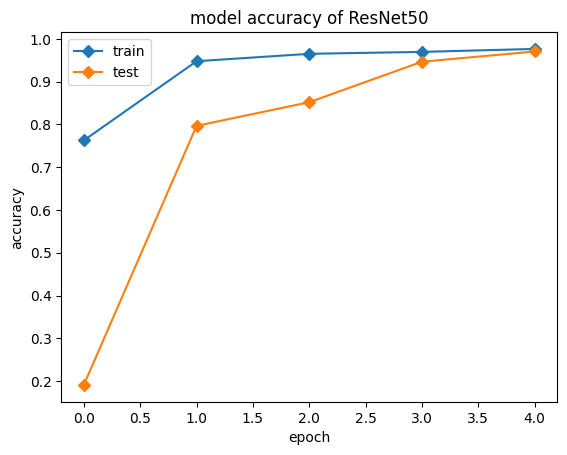

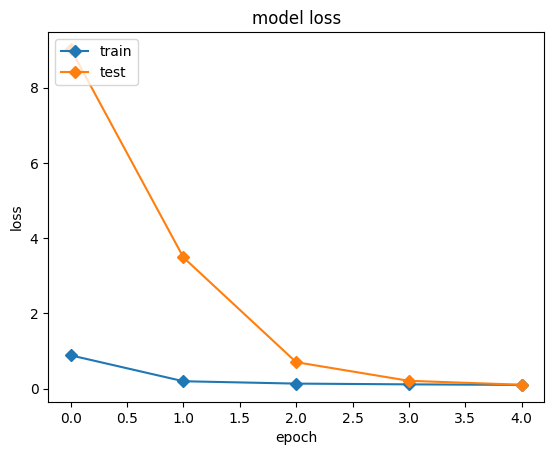

In [16]:
# график точности
plt.plot(history.history['accuracy'], marker='D')
plt.plot(history.history['val_accuracy'], marker='D')
plt.title('model accuracy of ResNet50')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# график потерь
plt.plot(history.history['loss'], marker='D')
plt.plot(history.history['val_loss'], marker='D')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

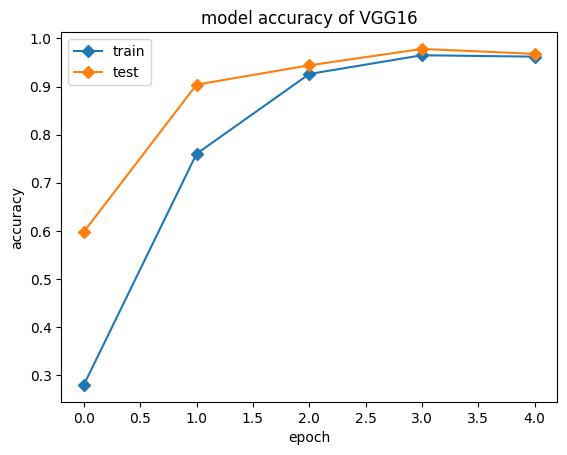

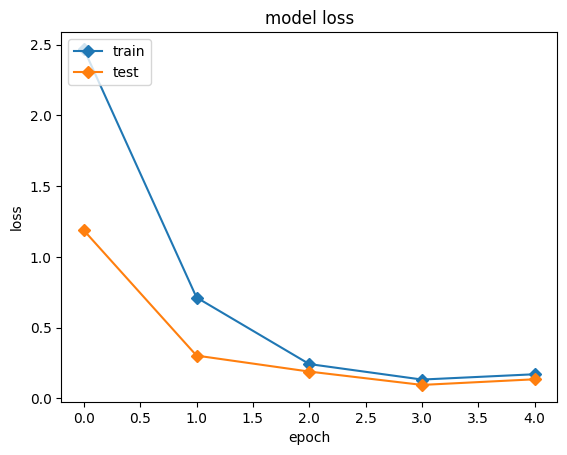

In [17]:
# график точности
plt.plot(history2.history['accuracy'], marker='D')
plt.plot(history2.history['val_accuracy'], marker='D')
plt.title('model accuracy of VGG16')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# график потерь
plt.plot(history2.history['loss'], marker='D')
plt.plot(history2.history['val_loss'], marker='D')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [18]:
tf.compat.v1.disable_eager_execution()
model=load_model('ResNet50.h5')
x_test = data[:1000]
y_test = y_test[:1000]
classifier = KerasClassifier(model=model, clip_values=(np.min(x_test), np.max(x_test)))

Instructions for updating:
Colocations handled automatically by placer.


In [19]:
# создание атаки FGSM
attack_fgsm = FastGradientMethod(estimator=classifier, eps=0.3)
eps_range = [1/255, 2/255, 3/255, 4/255, 5/255, 8/255, 10/255, 20/255, 50/255, 80/255]
true_accuracies = []
adv_accuracises_fgsm = []
true_losses = []
adv_losses_fgsm = []

for eps in eps_range:
    attack_fgsm.set_params(**{'eps': eps})
    print(f"Eps: {eps}")
    x_test_adv = attack_fgsm.generate(x_test, y_test)
    loss, accuracy = model.evaluate(x_test_adv, y_test)
    adv_accuracises_fgsm.append(accuracy)
    adv_losses_fgsm.append(loss)
    print(f"Adv Loss: {loss}")
    print(f"Adv Accuracy: {accuracy}")
    loss, accuracy = model.evaluate(x_test, y_test)
    true_accuracies.append(accuracy)
    true_losses.append(loss)
    print(f"True Loss: {loss}")
    print(f"True Accuracy: {accuracy}")

Eps: 0.00392156862745098


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


Adv Loss: 1.2983591508865358
Adv Accuracy: 0.7429999709129333
True Loss: 0.326266917347908
True Accuracy: 0.9229999780654907
Eps: 0.00784313725490196
Adv Loss: 2.3683586292266847
Adv Accuracy: 0.5979999899864197
True Loss: 0.326266917347908
True Accuracy: 0.9229999780654907
Eps: 0.011764705882352941
Adv Loss: 3.159928672790527
Adv Accuracy: 0.5109999775886536
True Loss: 0.326266917347908
True Accuracy: 0.9229999780654907
Eps: 0.01568627450980392
Adv Loss: 3.7946696701049807
Adv Accuracy: 0.4300000071525574
True Loss: 0.326266917347908
True Accuracy: 0.9229999780654907
Eps: 0.0196078431372549
Adv Loss: 4.328760940551758
Adv Accuracy: 0.37299999594688416
True Loss: 0.326266917347908
True Accuracy: 0.9229999780654907
Eps: 0.03137254901960784
Adv Loss: 5.506436809539795
Adv Accuracy: 0.23600000143051147
True Loss: 0.326266917347908
True Accuracy: 0.9229999780654907
Eps: 0.0392156862745098
Adv Loss: 5.978407218933105
Adv Accuracy: 0.1899999976158142
True Loss: 0.326266917347908
True Accurac

In [20]:
adv_losses_fgsm = np.array(adv_losses_fgsm)
adv_accuracises_fgsm = np.array(adv_accuracises_fgsm)
np.save("adv_losses_fgsm_ResNet50", adv_losses_fgsm)
np.save("adv_accuracises_fgsm_ResNet50", adv_accuracises_fgsm)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


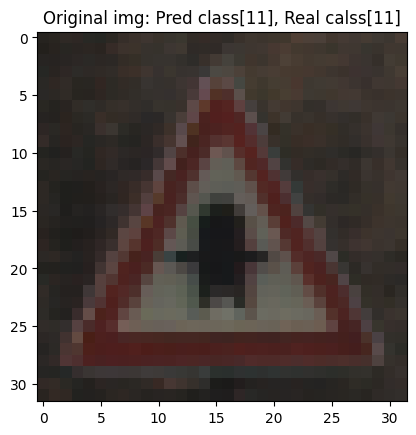

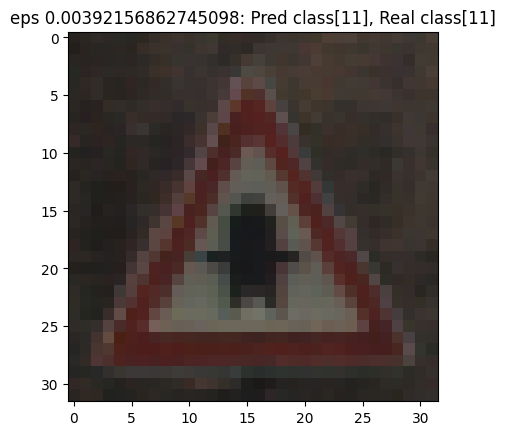

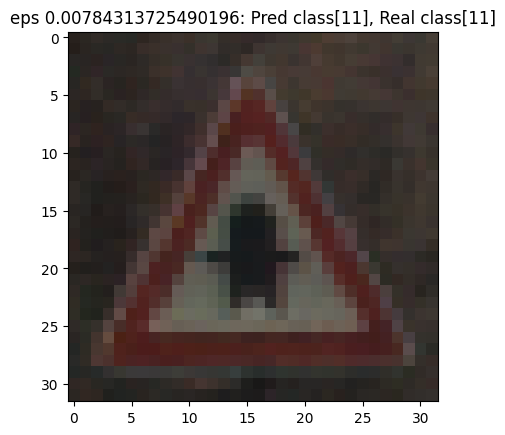

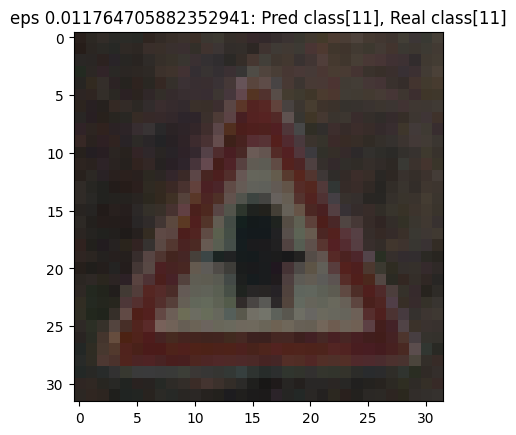

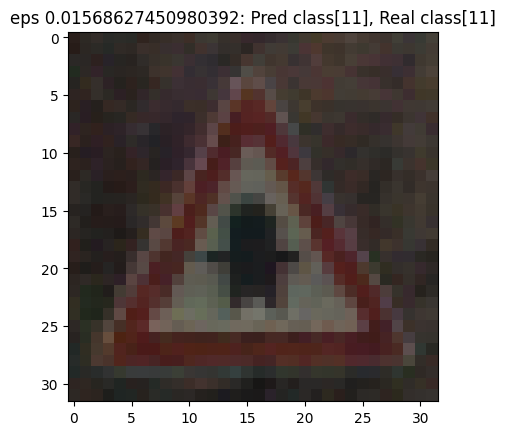

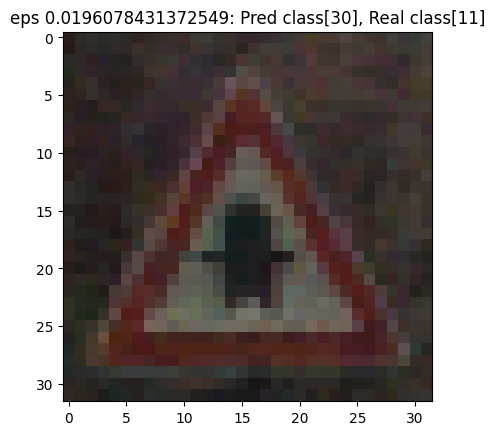

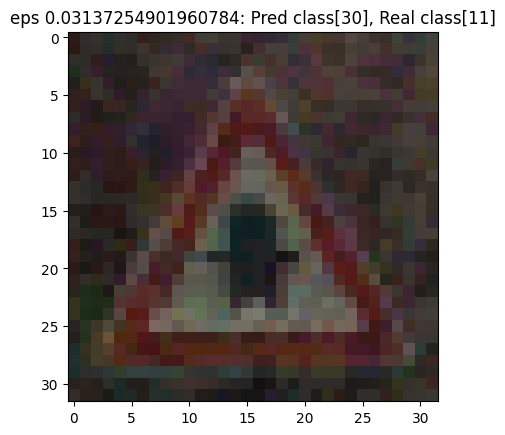

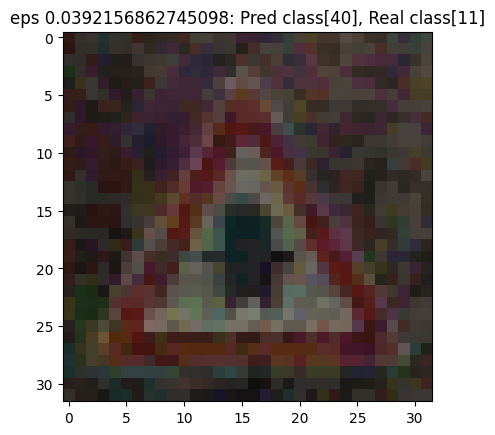

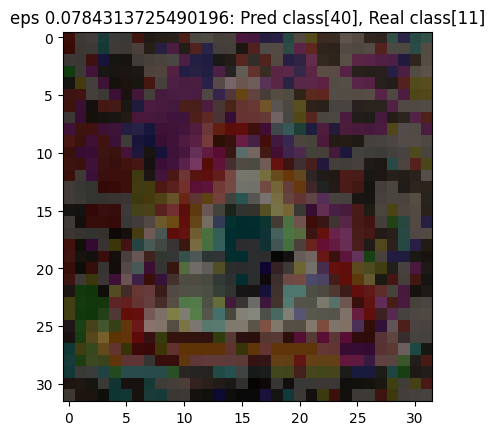

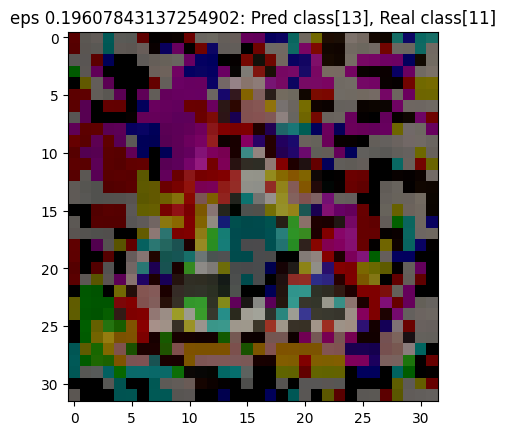

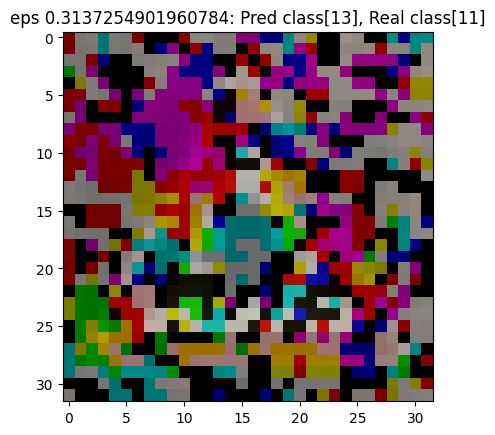

In [21]:
eps_range = [1/255, 2/255, 3/255, 4/255, 5/255, 8/255, 10/255, 20/255, 50/255, 80/255]
pred = np.argmax(model.predict(x_test[4:5]))
plt.figure(4)
plt.title(f"Original img: Pred class[{pred}], Real calss[{np.argmax(y_test[4])}]")
plt.imshow(x_test[4])
plt.show()
i = 1


for eps in eps_range:
    attack_fgsm.set_params(**{'eps': eps})
    x_test_adv = attack_fgsm.generate(x_test, y_test)
    pred = np.argmax(model.predict(x_test_adv[4:5]))
    plt.figure(i)
    plt.title(f"eps {eps}: Pred class[{pred}], Real class[{np.argmax(y_test[4])}]")
    plt.imshow(x_test_adv[4])
    plt.show()
    i += 1

In [22]:
tf.compat.v1.disable_eager_execution()
model=load_model('ResNet50.h5')
x_test = data[:1000]
y_test = y_test[:1000]
classifier = KerasClassifier(model=model, clip_values=(np.min(x_test), np.max(x_test)))
attack_pgd = ProjectedGradientDescent(estimator=classifier, eps=0.3, max_iter=4, verbose=False)
eps_range = [1/255, 2/255, 3/255, 4/255, 5/255, 8/255, 10/255, 20/255, 50/255, 80/255]
true_accuracies = []
adv_accuracises_pgd = []
true_losses = []
adv_losses_pgd = []


for eps in eps_range:
    attack_pgd.set_params(**{'eps': eps})
    print(f"Eps: {eps}")
    x_test_adv = attack_pgd.generate(x_test, y_test)
    loss, accuracy = model.evaluate(x_test_adv, y_test)
    adv_accuracises_pgd.append(accuracy)
    adv_losses_pgd.append(loss)
    print(f"Adv Loss: {loss}")
    print(f"Adv Accuracy: {accuracy}")
    loss, accuracy = model.evaluate(x_test, y_test)
    true_accuracies.append(accuracy)
    true_losses.append(loss)
    print(f"True Loss: {loss}")
    print(f"True Accuracy: {accuracy}")

Eps: 0.00392156862745098
Adv Loss: 1.5473374567031861
Adv Accuracy: 0.7080000042915344
True Loss: 0.326266917347908
True Accuracy: 0.9229999780654907
Eps: 0.00784313725490196
Adv Loss: 2.7574829444885256
Adv Accuracy: 0.5690000057220459
True Loss: 0.326266917347908
True Accuracy: 0.9229999780654907
Eps: 0.011764705882352941
Adv Loss: 3.6329756526947024
Adv Accuracy: 0.4860000014305115
True Loss: 0.326266917347908
True Accuracy: 0.9229999780654907
Eps: 0.01568627450980392
Adv Loss: 4.459725257873536
Adv Accuracy: 0.421999990940094
True Loss: 0.326266917347908
True Accuracy: 0.9229999780654907
Eps: 0.0196078431372549
Adv Loss: 5.235794551849366
Adv Accuracy: 0.35600000619888306
True Loss: 0.326266917347908
True Accuracy: 0.9229999780654907
Eps: 0.03137254901960784
Adv Loss: 6.628471572875976
Adv Accuracy: 0.2809999883174896
True Loss: 0.326266917347908
True Accuracy: 0.9229999780654907
Eps: 0.0392156862745098
Adv Loss: 7.473808536529541
Adv Accuracy: 0.24300000071525574
True Loss: 0.3262

In [23]:
adv_losses_pgd = np.array(adv_losses_pgd)
adv_accuracises_pgd = np.array(adv_accuracises_pgd)
np.save("adv_losses_pgd_ResNet50", adv_losses_pgd)
np.save("adv_accuracises_pgd_ResNet50", adv_accuracises_pgd)

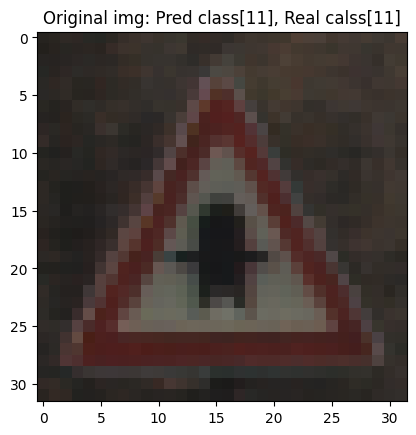

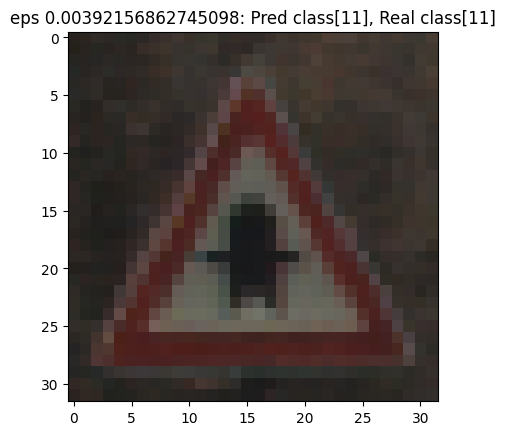

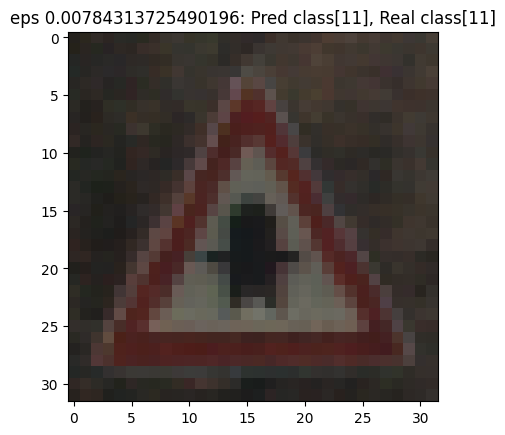

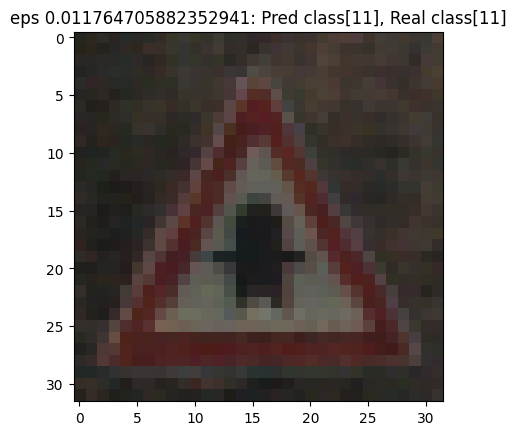

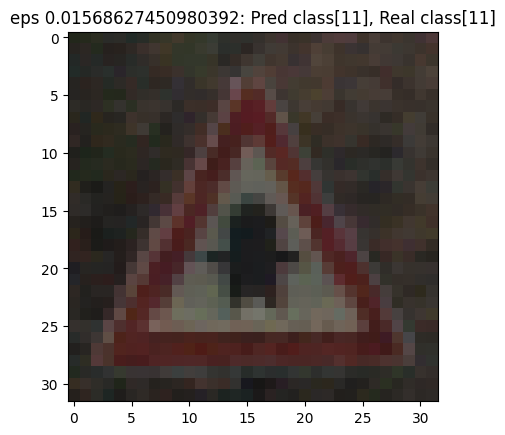

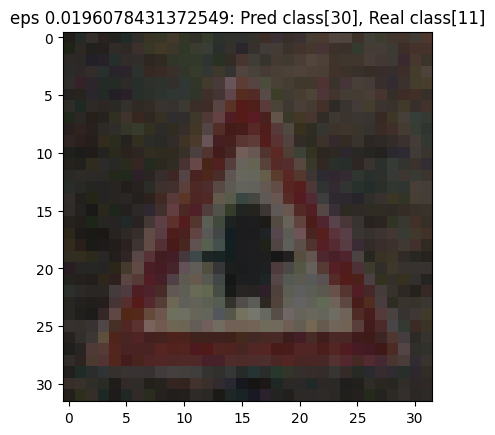

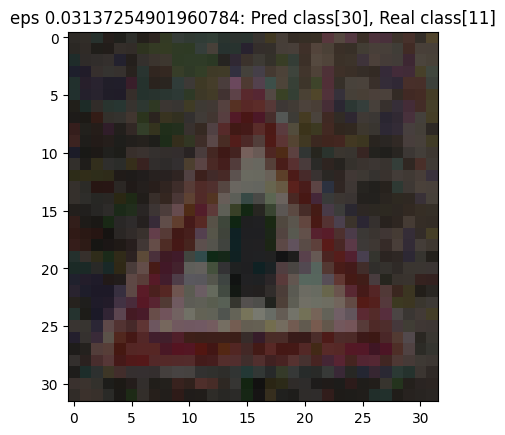

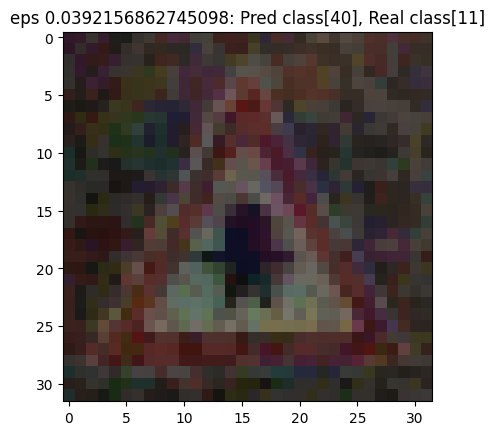

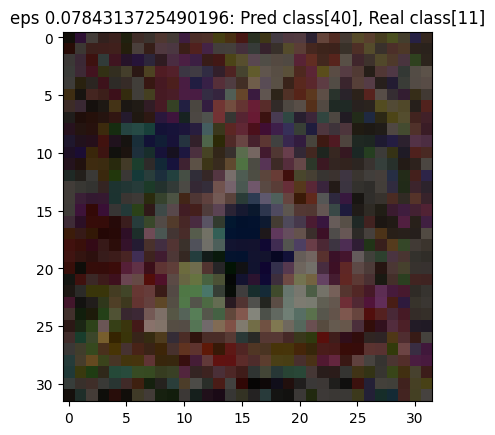

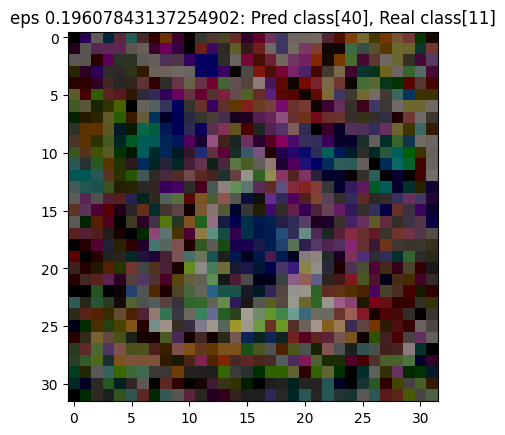

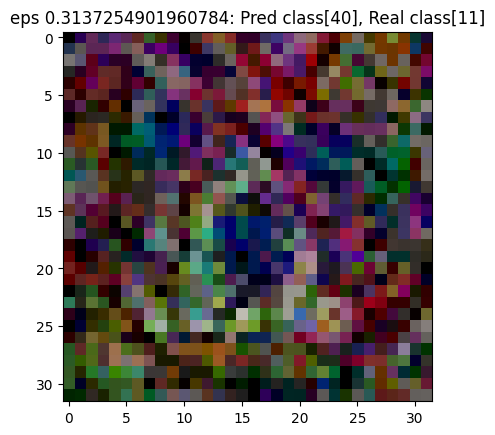

In [24]:
eps_range = [1/255, 2/255, 3/255, 4/255, 5/255, 8/255, 10/255, 20/255, 50/255, 80/255]
pred = np.argmax(model.predict(x_test[4:5]))
plt.figure(4)
plt.title(f"Original img: Pred class[{pred}], Real calss[{np.argmax(y_test[4])}]")
plt.imshow(x_test[4])
plt.show()
i = 1


for eps in eps_range:
    attack_pgd.set_params(**{'eps': eps})
    x_test_adv = attack_pgd.generate(x_test, y_test)
    pred = np.argmax(model.predict(x_test_adv[4:5]))
    plt.figure(i)
    plt.title(f"eps {eps}: Pred class[{pred}], Real class[{np.argmax(y_test[4])}]")
    plt.imshow(x_test_adv[4])
    plt.show()
    i += 1

In [25]:
tf.compat.v1.disable_eager_execution()
model=load_model('VGG16.h5')
x_test = data[:1000]
y_test = y_test[:1000]
classifier = KerasClassifier(model=model, clip_values=(np.min(x_test), np.max(x_test)))

In [26]:
attack_pgd = ProjectedGradientDescent(estimator=classifier, eps=0.3, max_iter=4, verbose=False)
eps_range = [1/255, 2/255, 3/255, 4/255, 5/255, 8/255, 10/255, 20/255, 50/255, 80/255]
true_accuracies = []
adv_accuracises_pgd = []
true_losses = []
adv_losses_pgd = []

for eps in eps_range:
    attack_pgd.set_params(**{'eps': eps})
    print(f"Eps: {eps}")
    x_test_adv = attack_pgd.generate(x_test, y_test)
    loss, accuracy = model.evaluate(x_test_adv, y_test)
    adv_accuracises_pgd.append(accuracy)
    adv_losses_pgd.append(loss)
    print(f"Adv Loss: {loss}")
    print(f"Adv Accuracy: {accuracy}")
    loss, accuracy = model.evaluate(x_test, y_test)
    true_accuracies.append(accuracy)
    true_losses.append(loss)
    print(f"True Loss: {loss}")
    print(f"True Accuracy: {accuracy}")

Eps: 0.00392156862745098
Adv Loss: 0.9918755350112916
Adv Accuracy: 0.8320000171661377
True Loss: 0.25439739334583283
True Accuracy: 0.9459999799728394
Eps: 0.00784313725490196
Adv Loss: 1.854921028137207
Adv Accuracy: 0.7390000224113464
True Loss: 0.25439739334583283
True Accuracy: 0.9459999799728394
Eps: 0.011764705882352941
Adv Loss: 2.451272367477417
Adv Accuracy: 0.6930000185966492
True Loss: 0.25439739334583283
True Accuracy: 0.9459999799728394
Eps: 0.01568627450980392
Adv Loss: 2.9431203289031984
Adv Accuracy: 0.6570000052452087
True Loss: 0.25439739334583283
True Accuracy: 0.9459999799728394
Eps: 0.0196078431372549
Adv Loss: 3.4851353435516357
Adv Accuracy: 0.6169999837875366
True Loss: 0.25439739334583283
True Accuracy: 0.9459999799728394
Eps: 0.03137254901960784
Adv Loss: 4.231658653259277
Adv Accuracy: 0.5540000200271606
True Loss: 0.25439739334583283
True Accuracy: 0.9459999799728394
Eps: 0.0392156862745098
Adv Loss: 4.714040090560913
Adv Accuracy: 0.5180000066757202
True L

In [27]:
adv_losses_pgd = np.array(adv_losses_pgd)
adv_accuracises_pgd = np.array(adv_accuracises_pgd)
np.save("adv_losses_pgd_VGG16", adv_losses_pgd)
np.save("adv_accuracises_pgd_VGG16", adv_accuracises_pgd)

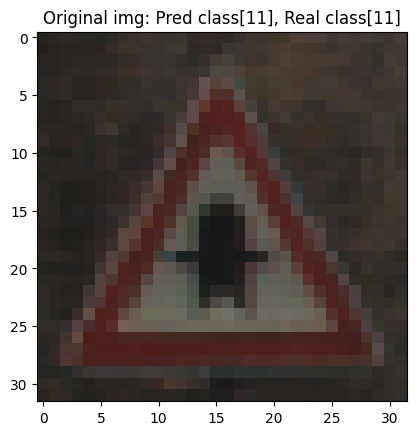

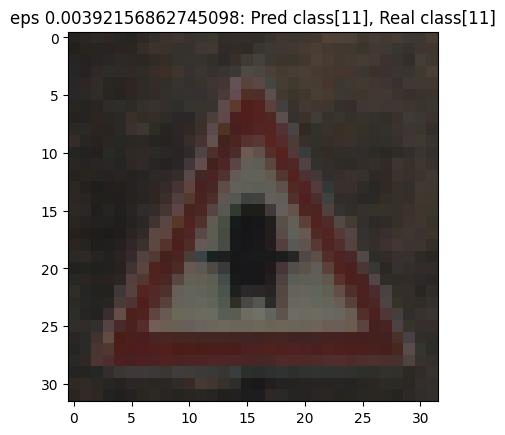

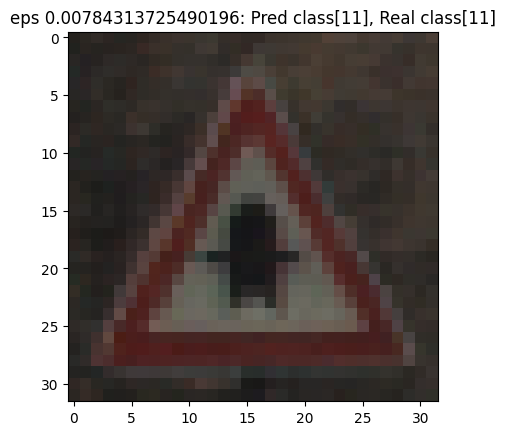

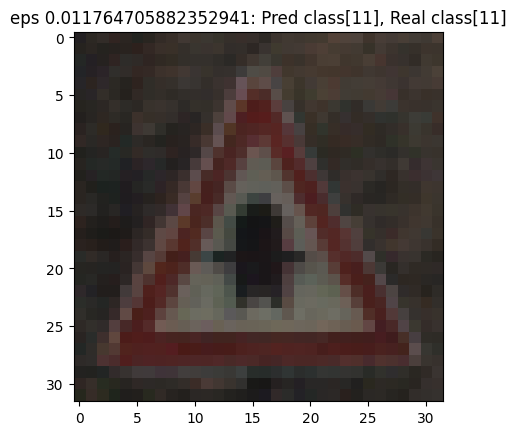

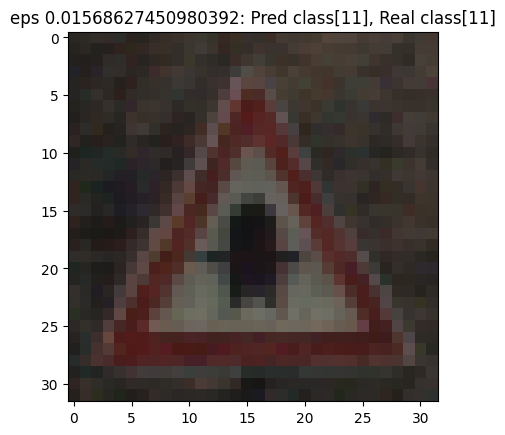

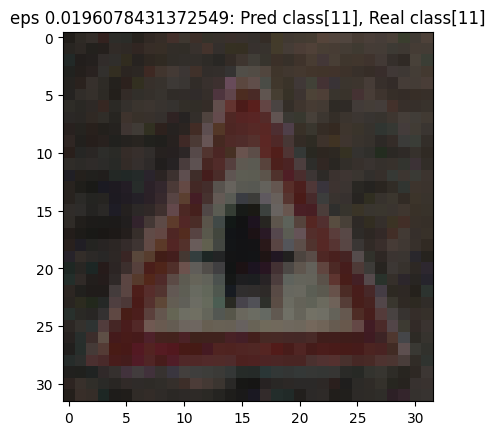

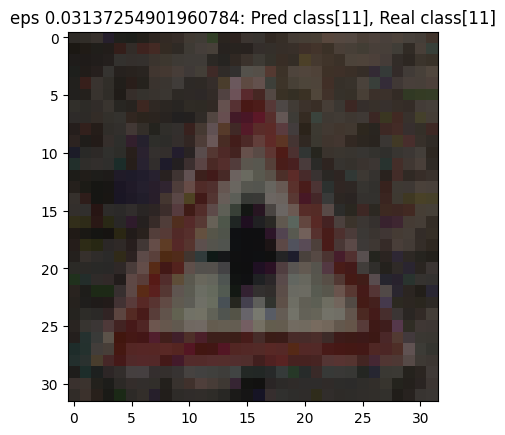

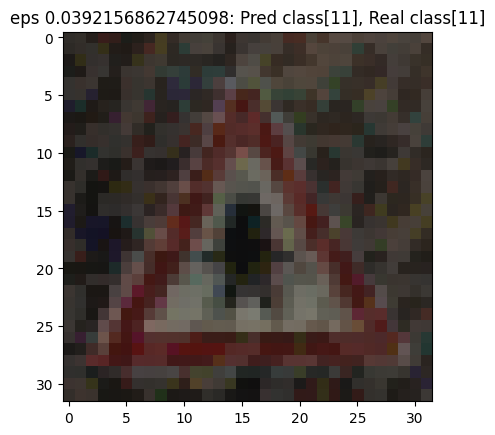

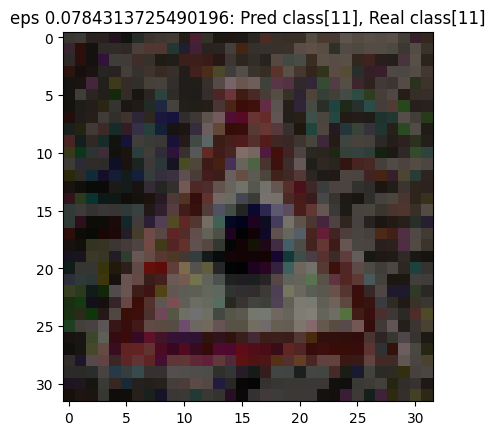

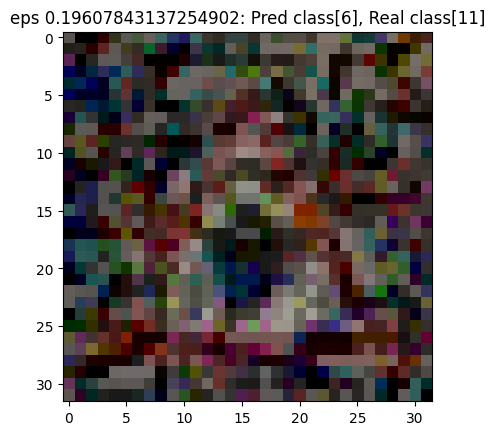

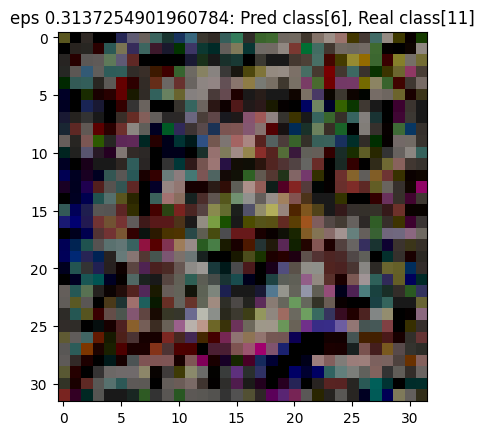

In [28]:
eps_range = [1/255, 2/255, 3/255, 4/255, 5/255, 8/255, 10/255, 20/255, 50/255, 80/255]
pred = np.argmax(model.predict(x_test[4:5]))
plt.figure(0)
plt.title(f"Original img: Pred class[{pred}], Real class[{np.argmax(y_test[4])}]")
plt.imshow(x_test[4])
plt.show()
i = 1


for eps in eps_range:
    attack_pgd.set_params(**{'eps': eps})
    x_test_adv = attack_pgd.generate(x_test, y_test)
    pred = np.argmax(model.predict(x_test_adv[4:5]))
    plt.figure(i)
    plt.title(f"eps {eps}: Pred class[{pred}], Real class[{np.argmax(y_test[4])}]")
    plt.imshow(x_test_adv[4])
    plt.show()
    i += 1


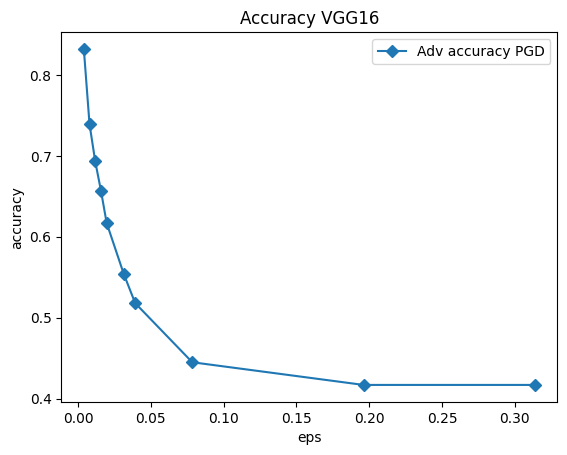

In [29]:
eps_range = [1/255, 2/255, 3/255, 4/255, 5/255, 8/255, 10/255, 20/255, 50/255, 80/255]
adv_accuracises_pgd = np.load("adv_accuracises_pgd_VGG16.npy")
plt.figure(0)
plt.plot(eps_range, adv_accuracises_pgd, label="Adv accuracy PGD", marker='D')
plt.title("Accuracy VGG16")
plt.xlabel("eps")
plt.ylabel("accuracy")
plt.legend()
plt.show()

In [30]:
adv_acc_fgsm_rn50 = np.load("adv_accuracises_fgsm_ResNet50.npy")
adv_acc_pgd_rn50 = np.load("adv_accuracises_pgd_ResNet50.npy")
adv_acc_pgd_v16 = np.load("adv_accuracises_pgd_VGG16.npy")

table = [["Model","Original accuracy","eps = 1/255","eps = 2/255", "eps = 3/255", "eps = 4/255", "eps = 5/255", "eps = 8/255", "eps = 10/255", "eps = 20/255", "eps = 50/255", "eps = 80/255" ],
            ["Resnet50 FGSM",train_accuracy[4]*100,adv_acc_fgsm_rn50[0]*100,
             adv_acc_fgsm_rn50[1]*100,adv_acc_fgsm_rn50[2]*100,adv_acc_fgsm_rn50[3]*100,
             adv_acc_fgsm_rn50[4]*100,adv_acc_fgsm_rn50[5]*100,adv_acc_fgsm_rn50[6]*100,
             adv_acc_fgsm_rn50[7]*100,adv_acc_fgsm_rn50[8]*100,adv_acc_fgsm_rn50[9]*100],
            ["Resnet50 PGD",train_accuracy[4]*100,adv_acc_pgd_rn50[0]*100,
             adv_acc_pgd_rn50[1]*100,adv_acc_pgd_rn50[2]*100,adv_acc_pgd_rn50[3]*100,
             adv_acc_pgd_rn50[4]*100,adv_acc_pgd_rn50[5]*100,adv_acc_pgd_rn50[6]*100,
             adv_acc_pgd_rn50[7]*100,adv_acc_pgd_rn50[8]*100,adv_acc_pgd_rn50[9]*100],
            ["VGG16 PGD",train_accuracy2[4]*100,adv_acc_pgd_v16[0]*100,
             adv_acc_pgd_v16[1]*100,adv_acc_pgd_v16[2]*100,adv_acc_pgd_v16[3]*100,
             adv_acc_pgd_v16[4]*100,adv_acc_pgd_v16[5]*100,adv_acc_pgd_v16[6]*100,
             adv_acc_pgd_v16[7]*100,adv_acc_pgd_v16[8]*100,adv_acc_pgd_v16[9]*100],
         ]

table2 = tabulate(table,headers="firstrow",tablefmt="grid")
print(table2)

+---------------+---------------------+---------------+---------------+---------------+---------------+---------------+---------------+----------------+----------------+----------------+----------------+
| Model         |   Original accuracy |   eps = 1/255 |   eps = 2/255 |   eps = 3/255 |   eps = 4/255 |   eps = 5/255 |   eps = 8/255 |   eps = 10/255 |   eps = 20/255 |   eps = 50/255 |   eps = 80/255 |
+===============+=====================+===============+===============+===============+===============+===============+===============+================+================+================+================+
| Resnet50 FGSM |             97.6499 |          74.3 |          59.8 |          51.1 |          43   |          37.3 |          23.6 |           19   |            9   |            6   |            5.1 |
+---------------+---------------------+---------------+---------------+---------------+---------------+---------------+---------------+----------------+----------------+---------------

In [31]:
test = pd.read_csv("Test.csv")
test_imgs = test['Path'].values
data = []
y_test = []
labels = test['ClassId'].values.tolist()
i = -1

for img in test_imgs:
    i += 1
    if labels[i] != 14:
      continue
    img = image.load_img(img, target_size=(32, 32))
    img_array = image.img_to_array(img)
    img_array = img_array /255
    data.append(img_array)
    y_test.append(labels[i])
data = np.array(data)
y_test = np.array(y_test)
y_test = to_categorical(y_test, 43)

In [32]:
model=load_model('ResNet50.h5')
tf.compat.v1.disable_eager_execution()
t_class = 1
t_class = to_categorical(t_class, 43)
t_classes = np.tile(t_class, (270, 1))
x_test = data
classifier = KerasClassifier(model=model, clip_values=(np.min(x_test), np.max(x_test)))
attack_fgsm = FastGradientMethod(estimator=classifier, eps=0.2, targeted=True, batch_size=64)
eps_range = [1/255, 2/255, 3/255, 4/255, 5/255, 8/255, 10/255, 20/255, 50/255, 80/255]

for eps in eps_range:
    attack_fgsm.set_params(**{'eps': eps})
    print(f"Eps: {eps}")
    x_test_adv = attack_fgsm.generate(x_test, t_classes)
    loss, accuracy = model.evaluate(x_test_adv, y_test)
    print(f"Adv Loss: {loss}")
    print(f"Adv Accuracy: {accuracy}")
    loss, accuracy = model.evaluate(x_test, y_test)
    print(f"True Loss: {loss}")
    print(f"True Accuracy: {accuracy}")

Eps: 0.00392156862745098


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


Adv Loss: 0.14246330371546112
Adv Accuracy: 0.9740740656852722
True Loss: 4.635895242996766e-08
True Accuracy: 1.0
Eps: 0.00784313725490196
Adv Loss: 0.6077750758992301
Adv Accuracy: 0.8999999761581421
True Loss: 4.635895242996766e-08
True Accuracy: 1.0
Eps: 0.011764705882352941
Adv Loss: 0.9747723959110401
Adv Accuracy: 0.8407407402992249
True Loss: 4.635895242996766e-08
True Accuracy: 1.0
Eps: 0.01568627450980392
Adv Loss: 1.5618505778136076
Adv Accuracy: 0.770370364189148
True Loss: 4.635895242996766e-08
True Accuracy: 1.0
Eps: 0.0196078431372549
Adv Loss: 2.18513369207029
Adv Accuracy: 0.6851851940155029
True Loss: 4.635895242996766e-08
True Accuracy: 1.0
Eps: 0.03137254901960784
Adv Loss: 4.540224998968619
Adv Accuracy: 0.37037035822868347
True Loss: 4.635895242996766e-08
True Accuracy: 1.0
Eps: 0.0392156862745098
Adv Loss: 5.708564719447383
Adv Accuracy: 0.1814814805984497
True Loss: 4.635895242996766e-08
True Accuracy: 1.0
Eps: 0.0784313725490196
Adv Loss: 7.03700131310357
Adv A

In [33]:
eps = 10/255
attack_fgsm.set_params(**{'eps': eps})
x_test_adv = attack_fgsm.generate(x_test, t_classes)

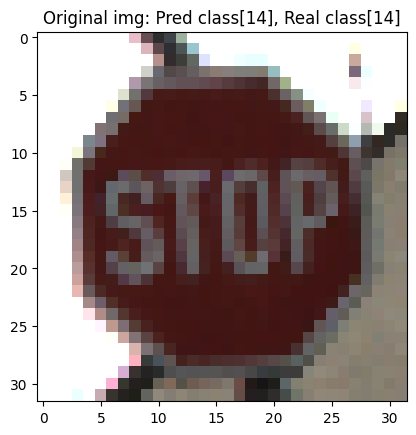

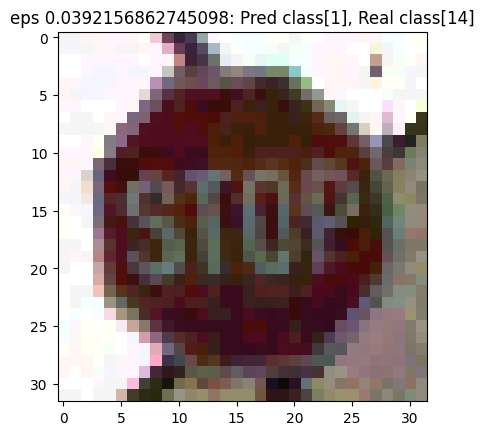

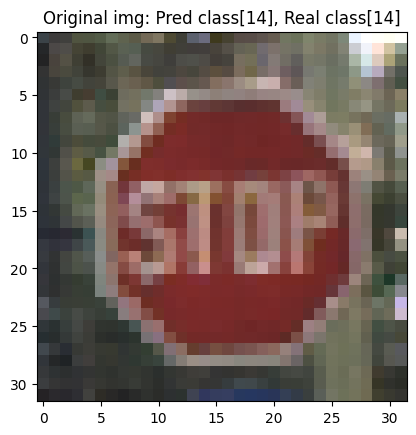

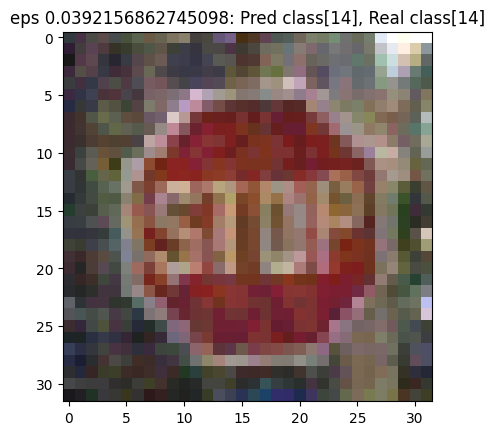

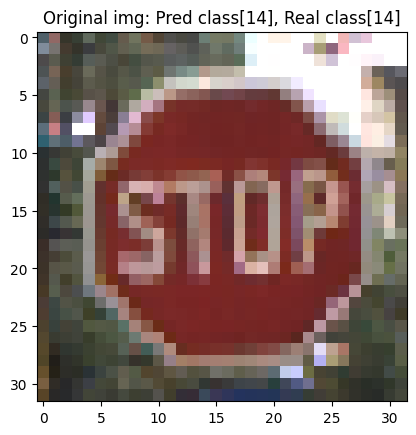

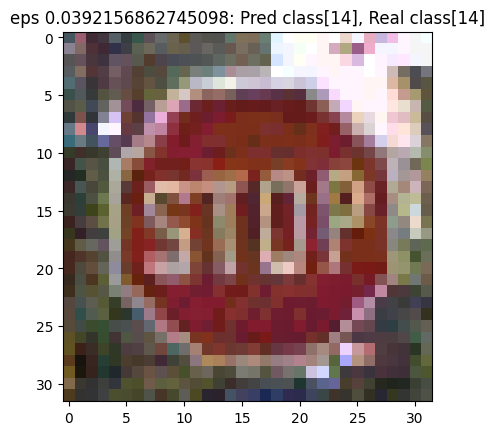

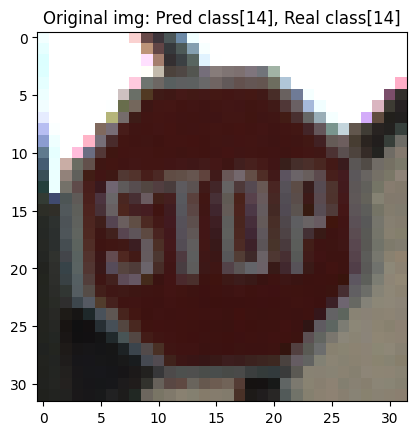

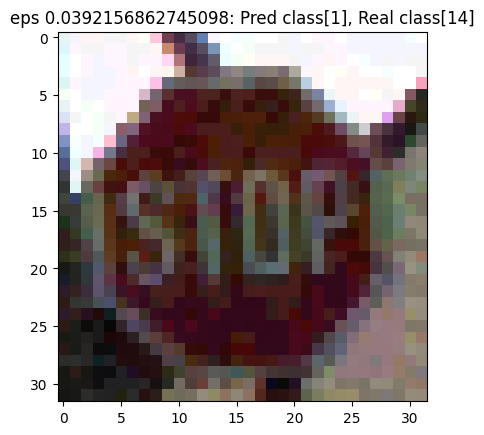

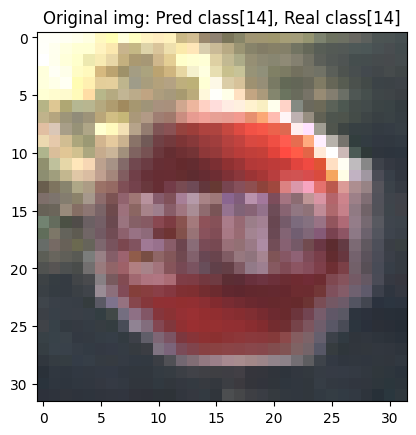

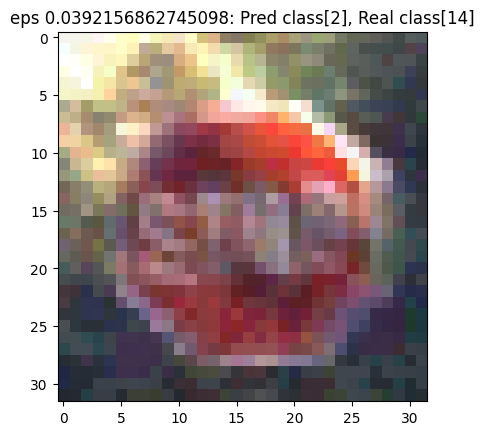

In [35]:
range = [0, 10, 20, 30, 40]
i = 0
for index in range:
  plt.figure(i)
  pred = np.argmax(model.predict(x_test[index:index+1]))
  plt.title(f"Original img: Pred class[{pred}], Real class[{np.argmax(y_test[index])}]")
  plt.imshow(x_test[index])
  plt.show()
  i += 1
  pred = np.argmax(model.predict(x_test_adv[index:index+1]))
  plt.figure(i)
  plt.title(f"eps {eps}: Pred class[{pred}], Real class[{np.argmax(y_test[index])}]")
  plt.imshow(x_test_adv[index])
  plt.show()

In [36]:
model=load_model('ResNet50.h5')
classifier = KerasClassifier(model=model, clip_values=(np.min(x_test), np.max(x_test)))
attack_pgd = ProjectedGradientDescent(estimator=classifier, eps=0.3, max_iter=4, verbose=False, targeted=True)
eps_range = [1/255, 2/255, 3/255, 4/255, 5/255, 8/255, 10/255, 20/255, 50/255, 80/255]

for eps in eps_range:
    attack_pgd.set_params(**{'eps': eps})
    print(f"Eps: {eps}")
    x_test_adv = attack_pgd.generate(x_test, t_classes)
    loss, accuracy = model.evaluate(x_test_adv, y_test)
    print(f"Adv Loss: {loss}")
    print(f"Adv Accuracy: {accuracy}")
    loss, accuracy = model.evaluate(x_test, y_test)
    print(f"True Loss: {loss}")
    print(f"True Accuracy: {accuracy}")

Eps: 0.00392156862745098
Adv Loss: 0.106712317300332
Adv Accuracy: 0.9740740656852722
True Loss: 4.635895242996766e-08
True Accuracy: 1.0
Eps: 0.00784313725490196
Adv Loss: 0.08037079579576298
Adv Accuracy: 0.9851852059364319
True Loss: 4.635895242996766e-08
True Accuracy: 1.0
Eps: 0.011764705882352941
Adv Loss: 0.27795188786274394
Adv Accuracy: 0.9407407641410828
True Loss: 4.635895242996766e-08
True Accuracy: 1.0
Eps: 0.01568627450980392
Adv Loss: 0.6416045363302584
Adv Accuracy: 0.885185182094574
True Loss: 4.635895242996766e-08
True Accuracy: 1.0
Eps: 0.0196078431372549
Adv Loss: 0.8427873496656064
Adv Accuracy: 0.8444444537162781
True Loss: 4.635895242996766e-08
True Accuracy: 1.0
Eps: 0.03137254901960784
Adv Loss: 1.4400361635066845
Adv Accuracy: 0.7851851582527161
True Loss: 4.635895242996766e-08
True Accuracy: 1.0
Eps: 0.0392156862745098
Adv Loss: 1.2549081714064987
Adv Accuracy: 0.8185185194015503
True Loss: 4.635895242996766e-08
True Accuracy: 1.0
Eps: 0.0784313725490196
Adv 

In [37]:
eps = 10/255
attack_pgd.set_params(**{'eps': eps})
x_test_adv = attack_pgd.generate(x_test, t_classes)

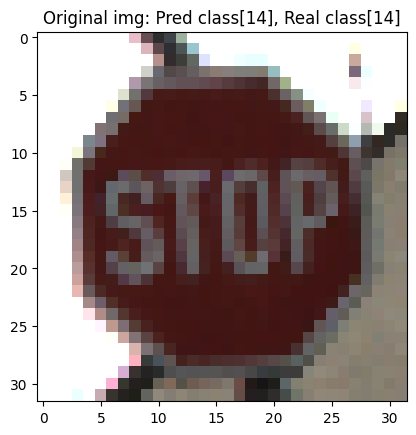

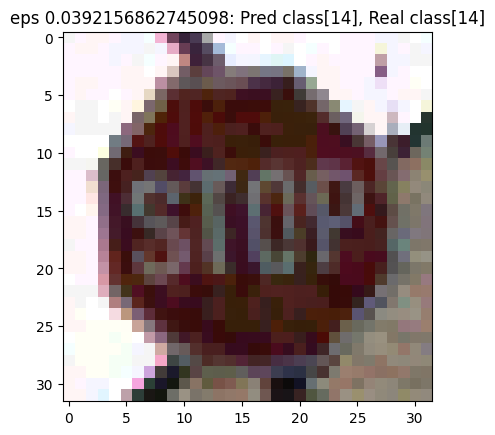

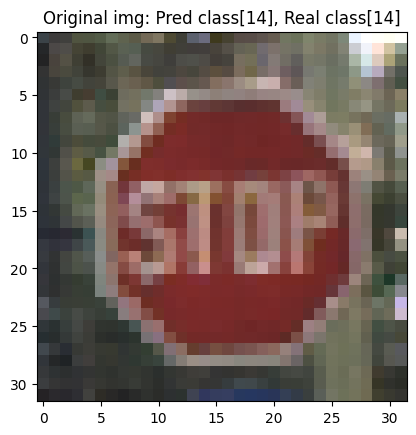

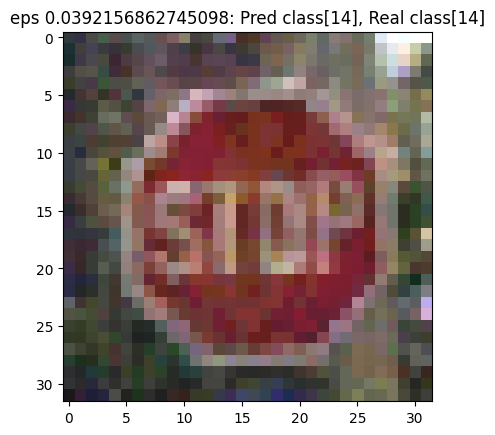

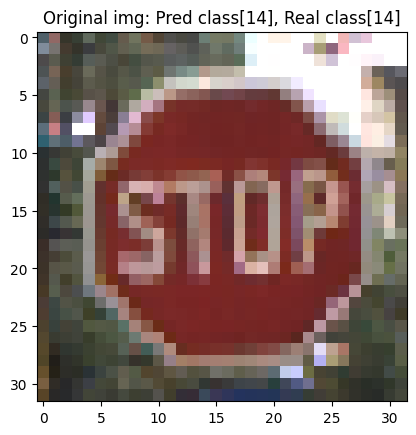

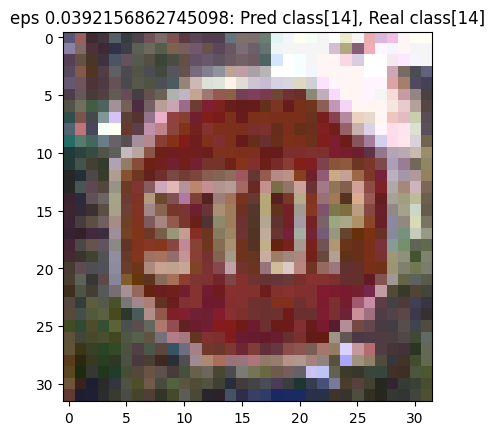

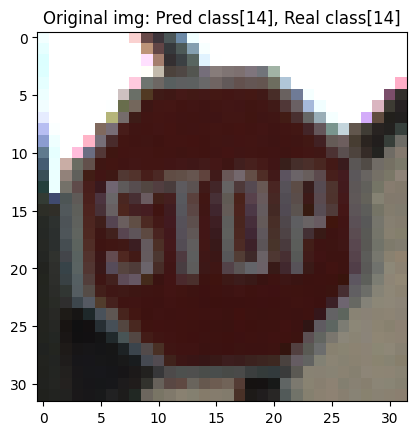

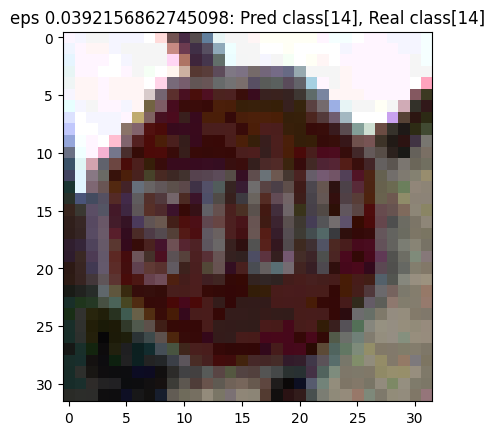

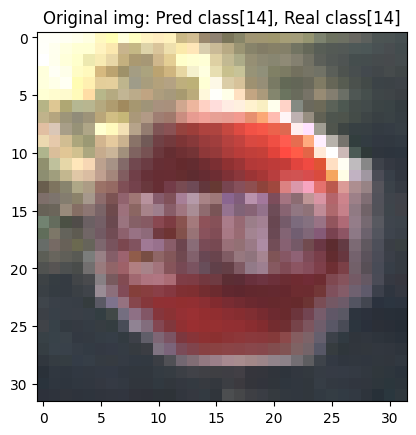

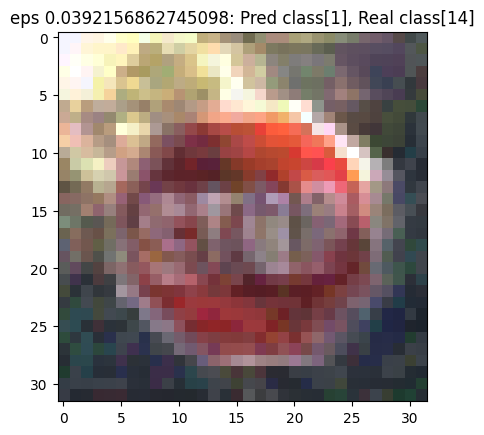

In [38]:
range = [0, 10, 20, 30, 40]
i = 0
for index in range:
  plt.figure(i)
  pred = np.argmax(model.predict(x_test[index:index+1]))
  plt.title(f"Original img: Pred class[{pred}], Real class[{np.argmax(y_test[index])}]")
  plt.imshow(x_test[index])
  plt.show()
  i += 1
  pred = np.argmax(model.predict(x_test_adv[index:index+1]))
  plt.figure(i)
  plt.title(f"eps {eps}: Pred class[{pred}], Real class[{np.argmax(y_test[index])}]")
  plt.imshow(x_test_adv[index])
  plt.show()